In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import corrections as cor
import uncertainties as unc
import iso_funcs as iso

In [2]:
#Definitions for how this code will work

outf = "new_edge_test/" #Folder to hold dataframes, so that different attempts can be compared, include '/' if not blank

ratios = [['He3','H2']]

#For debugging
debug = False

#Turn on and off portions
drop_edge = True #Whether or not to drop edge bins, I want to evaluate the difference between dropping and not dropping
do_yield = True
do_ratio = True
do_average = True
do_corrections = True
do_coulomb = True
do_bincenter = True
do_radout = True
do_radapply = True
do_isoapply = True

In [3]:
#Define x bins
x_edges = np.arange(0,1.01,0.03)
x_centers = [round(x+0.015,3) for x in x_edges]  #Round because of float inaccuracies
del x_centers[-1] #Last element is outside of range

if not debug:
    #String of kins used for finding the runlists
    kins = ['0','1','2','3','4','5','7_1st','7_2nd','9_1st','9_2nd','11_1st','11_2nd','13_1st','13_2nd','15_1st','15_2nd','15_3rd','16_1st','16_2nd']
    targs = ['H3','He3','H2','H1']
else:
    #Small lists for testing
    kins = ['2']
    targs = ['He3','H2']

#Run Metadata
meta = pd.read_csv("ev_clean/meta.csv",index_col='run')

#Model XS data for coulomb correction and bin centering
xs_mod = pd.read_csv("models/KP_sig.csv")

In [4]:
if do_yield:
    for targ in targs:
        #print(targ)
        #Get target specific functions
        sc = getattr(cor,targ + 'Nuclei')
        pn = getattr(cor,targ + 'Nucleons')
        be = getattr(unc,targ + 'BoilingUnc')
        bc = getattr(cor,targ + 'Boiling')

        for i,kin in enumerate(kins):
            #print(kin)
            #Running sum of kinematic charge
            kinQ = 0

            #Running sum of kinematic Boiling Uncertainty
            #Boiling uncertainty is 100% correlated so in a kinematic it is summed linearly rather than quadratically
            kinBoilE = pd.Series

            #Yield Dataframe for a kinematic
            df = pd.DataFrame(columns=['Yield','Counts','RelStat','RelSyst','xSum','Q2Sum','BinCenter','BoilErr'])
            df.BinCenter = x_centers

            #Dataframe for a run
            rdf = pd.DataFrame(columns=['Yield','Counts','xSum','Q2Sum','BoilErr','BinCenter'])
            rdf.BinCenter = x_centers

            #Initialize values
            df['Yield'].values[:] = 0
            df['Counts'].values[:] = 0
            df['RelStat'].values[:] = 0
            df['RelSyst'].values[:] = 0
            df['xSum'].values[:] = 0
            df['Q2Sum'].values[:] = 0
            rdf['Yield'].values[:] = 0
            rdf['Counts'].values[:] = 0
            rdf['xSum'].values[:] = 0
            rdf['Q2Sum'].values[:] = 0
            rdf['BoilErr'].values[:] = 0

            try:
                with open("./runlists/" + targ + "_kin" + kin + ".dat","r") as f:
                    runs = f.read().splitlines()

                    for run in runs:
                        #Load run
                        ev = pd.read_csv("ev_clean/" + run + ".csv")
                        #ev.query('W2>4.0',inplace=True)

                        #Add in this runs charge
                        kinQ = kinQ + meta.at[int(run),'Q']

                        #Bin in x
                        ev['x_bin'] = np.digitize(ev.x,x_edges)

                        for j in range(len(x_centers)):
                            tmp = ev.query('x_bin==' + str(j+1))
                            rdf.Counts.iat[j] = tmp.shape[0]
                            rdf.xSum.iat[j] = tmp.x.sum()
                            rdf.Q2Sum.iat[j] = tmp.Q2.sum()

                        #Apply livetime
                        rdf.Yield = rdf.Counts.apply(lambda x: x/meta.at[int(run),'lt'])
                        if debug:
                            rdf.to_csv("debug/lt/" + run + ".csv")

                        if debug:
                            rdf.Yield /= kinQ
                            rdf.to_csv("debug/q/" + run + ".csv")

                        #Divide by scattering centers
                        #sc = getattr(cor,targ + 'Nuclei')
                        rdf.Yield = rdf.Yield.apply(lambda x: x/sc(meta.at[int(run),'avgI']))

                        #Convert to per nucleon yield
                        #pn = getattr(cor,targ + 'Nucleons')
                        rdf.Yield = rdf.Yield.apply(lambda x: x/pn())
                        if debug:
                            rdf.to_csv("debug/sc/" + run + ".csv")

                        #Calculate and sum boiling Uncertainty
                        #be = getattr(unc,targ + 'BoilingUnc')
                        #bc = getattr(cor,targ + 'Boiling')
                        rdf.BoilErr = rdf.Yield.apply(lambda x: be(meta.at[int(run),'avgI'])*x/bc(meta.at[int(run),'avgI']))

                        #Add run to kinematic sum
                        df['Yield'] += rdf['Yield']
                        df['Counts'] += rdf['Counts']
                        df['xSum'] += rdf['xSum']
                        df['Q2Sum'] += rdf['Q2Sum']
                        #Boiling Uncertaintys are 100% correlated. Must sum them run-by-run, then determine relative Uncertainty from the total.
                        df['RelSyst'] += rdf['BoilErr']

                        rdf['Yield'].values[:] = 0
                        rdf['Counts'].values[:] = 0
                        rdf['xSum'].values[:] = 0
                        rdf['Q2Sum'].values[:] = 0
                        rdf['BoilErr'].values[:] = 0

                    if not debug:
                        #Calculate kinematic statistical Uncertainty
                        df.RelStat = df.Counts.apply(lambda x: 1./math.sqrt(x) if x!=0 else 0)

                        #Boiling Uncertainty is "Absolute uncertainty". Make it relative.
                        df.RelSyst = df.apply(lambda x: x.RelSyst/x.Yield if x.Yield!=0 else 0, axis=1)
                        df.BoilErr = df.RelSyst

                        #Subtract positrons and Combine Positron Uncertainty in quadrature
                        #pc = getattr(cor,targ+'Positrons')
                        #pe = getattr(unc,targ+'PositronsUnc')
                        #df.RelSyst = df.apply(lambda x: (x.RelSyst**2 + (pe(x.BinCenter)**2)/(pc(x.BinCenter))**2)**(1./2.) if x.Yield!=0 else 0, axis=1)
                        #df.Yield = df.Yield * df.BinCenter.apply(pc)

                        #Charge Normalize
                        df.Yield /= kinQ
                        #df.Yield /= pn()
                        df.to_csv(outf + "dataframes/kinyield1/" + targ + "/kin" + kin + ".csv")

                    #Prep files for radiative correction calculations
    #                 rp = open("./radcor/rp/" + targ + "_kin" + kin + ".txt","w")
    #                 rp.write("n   xbj   Q2\n")
    #                 rp.writelines([str(bc) + ", " + str(xsum/counts) + ", " + str(q2sum/counts) + "\n" for (bc,counts,xsum,q2sum) in zip(df['BinCenter'],df['Counts'],df['xSum'],df['Q2Sum']) if counts!=0])
    #                 rp.close()

    #                 inp = open("./radcor/inp/" + targ + kin + ".inp","w")
    #                 inp.write("input files for EXTERNAL: runplan/target/output\n")
    #                 inp.write("RUNPLAN/" + targ + "_kin" + kin + ".inp\n")
    #                 inp.write("TARG/targ." + targ + "\n")
    #                 inp.write("OUT/" + targ + "_" + kin + ".out\n\n")
    #                 inp.close()

            except FileNotFoundError as e:
                print (e.filename + " File doesn't exist. Skipping.")
                #This will print for H1 kinematics greater than 4, though perhaps I ought to create a less "error-driven" approach since those kinematics do not exist.

./runlists/H1_kin5.dat File doesn't exist. Skipping.
./runlists/H1_kin7_1st.dat File doesn't exist. Skipping.
./runlists/H1_kin7_2nd.dat File doesn't exist. Skipping.
./runlists/H1_kin9_1st.dat File doesn't exist. Skipping.
./runlists/H1_kin9_2nd.dat File doesn't exist. Skipping.
./runlists/H1_kin11_1st.dat File doesn't exist. Skipping.
./runlists/H1_kin11_2nd.dat File doesn't exist. Skipping.
./runlists/H1_kin13_1st.dat File doesn't exist. Skipping.
./runlists/H1_kin13_2nd.dat File doesn't exist. Skipping.
./runlists/H1_kin15_1st.dat File doesn't exist. Skipping.
./runlists/H1_kin15_2nd.dat File doesn't exist. Skipping.
./runlists/H1_kin15_3rd.dat File doesn't exist. Skipping.


#Now run radiative corrections on ksu1 machine. Bring the 'xs' files back to the radcor/out directory.

Skipping radiative corrections until the end. Now to take ratios, combine iterations, and drop edge bins.

In [5]:
if do_ratio:
    #Target ratios
    for ratio in ratios:
        for kin in kins:
            num = pd.read_csv(outf+"dataframes/kinyield1/" + ratio[0] + "/kin" + kin + ".csv",index_col=0)
            den = pd.read_csv(outf+"dataframes/kinyield1/" + ratio[1] + "/kin" + kin + ".csv",index_col=0)
            num

            df = pd.DataFrame(columns=['Ratio','Counts','RelStat','RelSyst','BinCenter','BoilErr'])
            df.BinCenter = x_centers

            df.Ratio = num.Yield/den.Yield
            df.Ratio = df.Ratio.apply(lambda x: x if not np.isnan(x) else 0)
            df.RelStat = (num.RelStat**2 + den.RelStat**2).apply(math.sqrt)
            df.RelSyst = (num.RelSyst**2 + den.RelSyst**2).apply(math.sqrt)
            df.BoilErr = (num.BoilErr**2 + den.BoilErr**2).apply(math.sqrt)
            df.Counts = num.Counts + den.Counts

            df.to_csv(outf + "dataframes/ratios1/" + ratio[0] + "_" + ratio[1] + "/kin" + kin + ".csv")

In [6]:
if do_average:
    #Combine iterations
    for ratio in ratios:
        df = pd.DataFrame(columns=['Ratio','Counts','RelSyst','BinCenter','mean_num','inv_var'])
        df.BinCenter = x_centers
        df['Ratio'].values[:] = 0
        df['Counts'].values[:] = 0
        df['RelSyst'].values[:] = 0
        #df['BoilErr'].values[:] = 0
        df['mean_num'].values[:] = 0
        df['inv_var'].values[:] = 0
        for i,kin in enumerate(kins):
            kin_df = pd.read_csv(outf+"dataframes/ratios1/" + ratio[0] + "_" + ratio[1] + "/kin" + kin + ".csv", index_col=0)
            
            #Drop edge bins, that is first and last bin with a non-zero ratio
            if drop_edge==True or kin=='16_1st' or kin=='16_2nd' or kin=='0':
                first = kin_df.index[kin_df.Ratio!=0][0]
                last = kin_df.index[kin_df.Ratio!=0][-1]

                kin_df.at[first,'Ratio']=0
                kin_df.at[first,'RelStat']=0
                kin_df.at[first,'RelSyst']=0
                kin_df.at[first,'Counts']=0
                kin_df.at[first,'BoilErr']=0
                
                kin_df.at[last,'Ratio']=0
                kin_df.at[last,'RelStat']=0
                kin_df.at[last,'RelSyst']=0
                kin_df.at[last,'Counts']=0
                kin_df.at[last,'BoilErr']=0

            #Calculate the numerator and denominator for weighted average and uncertainty
            #Also keep track of counts for rough estimate of stat error
            df.mean_num += kin_df.apply(lambda x: x.Ratio/(x.RelStat**2 + x.RelSyst**2) if x.Ratio!=0 else 0, axis=1)
            df.inv_var += kin_df.apply(lambda x: 1./(x.RelStat**2 + x.RelSyst**2) if x.Ratio!=0 else 0, axis=1)
            df.Counts += kin_df.Counts

        df.Ratio = df.apply(lambda x: x.mean_num/x.inv_var if x.inv_var!=0 else 0, axis=1)
        df['RelPre'] = df.inv_var.apply(lambda x: math.sqrt(1/x) if x!=0 else 0)
        df = df.drop(columns = ['mean_num','inv_var'])
        df = df[df.Ratio != 0]
        df.reset_index(drop=True,inplace=True)
        df.to_csv(outf + "dataframes/ratio_nocor/" + ratio[0] + "_" + ratio[1] + ".csv")

Ratio is now calculated with only boiling corrections. Now other corrections must be applied and their errors determined.

In [7]:
if do_corrections:
    for ratio in ratios:
        df = pd.read_csv(outf + "dataframes/ratio_nocor/" + ratio[0] + "_" + ratio[1] + ".csv", index_col=0)
        
        #Subtract positrons and Combine Positron Uncertainty in quadrature
        npc = getattr(cor,ratio[0] + 'Positrons')
        npe = getattr(unc,ratio[0] + 'PositronsUnc')
        dpc = getattr(cor,ratio[1] + 'Positrons')
        dpe = getattr(unc,ratio[1] + 'PositronsUnc')
        ecc = getattr(cor,ratio[0] + ratio[1] + 'ECC')
        ecce = getattr(unc,ratio[0] + ratio[1] + 'ECCerror')
        
        df['PositronCor'] = df.BinCenter.apply(npc) / df.BinCenter.apply(dpc)
        df.Ratio = df.Ratio * df.PositronCor
        #df.RelSyst = df.apply(lambda x: (x.RelSyst**2 + (npe(x.BinCenter)**2)/(npc(x.BinCenter))**2 + (dpe(x.BinCenter)**2)/(dpc(x.BinCenter))**2)**(1./2.) if x.Ratio!=0 else 0, axis=1)
        df['PositronError'] = df.apply(lambda x:((npe(x.BinCenter)**2)/(npc(x.BinCenter))**2 + (dpe(x.BinCenter)**2)/(dpc(x.BinCenter))**2)**(1./2.) if x.Ratio!=0 else 0, axis=1)
        df.RelSyst = df.apply(lambda x: (x.RelSyst**2 + x.PositronError**2)**(1./2.) if x.Ratio!=0 else 0, axis=1)
        
        #Endcap contamination subtraction
        df['ECCCor'] = df.BinCenter.apply(ecc)
        df.Ratio = df.Ratio * df.ECCCor
        #df.RelSyst = df.apply(lambda x: (x.RelSyst**2 + (ecce(x.BinCenter)**2)/(ecc(x.BinCenter)**2))**(1./2.) if x.Ratio!=0 else 0, axis=1)
        df['ECCError'] = df.apply(lambda x: ((ecce(x.BinCenter)**2)/(ecc(x.BinCenter)**2))**(1./2.) if x.Ratio!=0 else 0, axis=1)
        df.RelSyst = df.apply(lambda x: (x.RelSyst**2 + x.ECCError**2)**(1./2.) if x.Ratio!=0 else 0, axis=1)

        
        #display(df)
        df.to_csv(outf + "dataframes/ratio_cor1/" + ratio[0] + "_" + ratio[1] + ".csv")

In [8]:
#Do coulomb correction based on effective Q^2 model and do bin centering

#Order of polynomial for fit
poly_order = 5

#Define a function to calculate the error of fits at a given bin center
def fit_err(bc, cov, n):
    #Parameters:
    #bc - The bin center to calculate the error at
    #cov - The covariance matrix of the fit
    #n - The polynomial order of the fit, cov should by an (n+1) x (n+1) ndarray
    h = np.ndarray(shape=(1,n+1))
    v = np.ndarray(shape=(n+1,1))
    for x in range(n+1):
        h[0][x] = bc**(n-x)
        v[x][0] = bc**(n-x)
    
    return np.dot(np.dot(h,cov),v)[0][0]

#Define a function to calculate the error of the integration of a fit at a given value
def int_err(bc, cov, n):
    #Parameters:
    #bc - The bin center to calculate the error at
    #cov - The covariance matrix of the fit
    #n - The polynomial order of the fit, cov should by an (n+1) x (n+1) ndarray
    h = np.ndarray(shape=(1,n+1))
    v = np.ndarray(shape=(n+1,1))
    for x in range(n+1):
        h[0][x] = bc**(n-x+1) / (n-x+1)
        v[x][0] = bc**(n-x+1) / (n-x+1)
    
    return np.dot(np.dot(h,cov),v)[0][0]

fit_errv = np.vectorize(fit_err)

for ratio in ratios:
    df = pd.read_csv(outf + "dataframes/ratio_cor1/" + ratio[0] + "_" + ratio[1] + ".csv", index_col=0)
    #Get a fit of the model
    r0_fit, r0_cov = np.polyfit(xs_mod.x,xs_mod[ratio[0] + 'logsig'],poly_order,full=False,cov=True)
    r1_fit, r1_cov = np.polyfit(xs_mod.x,xs_mod[ratio[1] + 'logsig'],poly_order,full=False,cov=True)
    if do_coulomb:
        #Get charge number of targets
        r0z = getattr(cor,ratio[0] + 'Z')()
        r1z = getattr(cor,ratio[1] + 'Z')()
        
        #Get Hard Sphere equivalent radius of targets
        r0R = getattr(cor,ratio[0] + 'HSR')()
        r1R = getattr(cor,ratio[1] + 'HSR')()
        
        #Calculate Effective Q^2 correction factor
        #This multiplies straight through to get Effective Bjorken x
        r0C2 = (1. + ((0.00432*r0z)/(2.*r0R*10.586)))**2.
        r1C2 = (1. + ((0.00432*r1z)/(2.*r1R*10.586)))**2.
        
        df.Ratio = df.apply(lambda x: x.Ratio * np.exp(np.polyval(r0_fit,x.BinCenter) + np.polyval(r1_fit,x.BinCenter*r1C2) - (np.polyval(r0_fit,x.BinCenter*r0C2) + np.polyval(r1_fit,x.BinCenter))), axis=1)
        df['CCor'] = df.apply(lambda x: np.exp(np.polyval(r0_fit,x.BinCenter) + np.polyval(r1_fit,x.BinCenter*r1C2) - (np.polyval(r0_fit,x.BinCenter*r0C2) + np.polyval(r1_fit,x.BinCenter))) if x.Ratio!=0 else 0, axis=1)
        
        #Calculate uncertainties
        #r0cen_err = (np.vectorize(np.polyval))(r0_fit,df.BinCenter) * (np.vectorize(np.sqrt))(fit_errv(df.BinCenter, r0_cov, poly_order))
        df['Rel' + ratio[0] + 'CCorErr'] = df.apply(lambda x: np.sqrt(fit_err(x.BinCenter, r0_cov, poly_order) + fit_err(x.BinCenter*r0C2, r0_cov, poly_order)) if x.Ratio!=0 else 0, axis=1)
        df['Rel' + ratio[1] + 'CCorErr'] = df.apply(lambda x: np.sqrt(fit_err(x.BinCenter, r1_cov, poly_order) + fit_err(x.BinCenter*r1C2, r1_cov, poly_order)) if x.Ratio!=0 else 0, axis=1)
        df['RelCCorError'] = (df['Rel' + ratio[0] + 'CCorErr']**2 + df['Rel' + ratio[1] + 'CCorErr']**2).apply(np.sqrt)
        df.RelSyst = df.apply(lambda x: (x.RelSyst**2 + x.RelCCorError**2)**(1./2.) if x.Ratio!=0 else 0, axis=1)
        df = df.drop(columns = ['Rel' + ratio[0] + 'CCorErr', 'Rel' + ratio[1] + 'CCorErr'])
        df.to_csv(outf + "dataframes/ratio_cor2/" + ratio[0] + "_" + ratio[1] + ".csv")
        
        #display(r0cen_err)
    
    if do_bincenter:
        #Integrate the fits for calculating the expectation value
        r0_fint = np.polyint(r0_fit)
        r1_fint = np.polyint(r1_fit)
        
        df.Ratio = df.apply(lambda x: x.Ratio * np.exp(np.polyval(r0_fit,x.BinCenter) + ((np.polyval(r1_fint,x.BinCenter+0.015) - np.polyval(r1_fint, x.BinCenter-0.015))/0.03) - ((np.polyval(r0_fint,x.BinCenter+0.015) - np.polyval(r0_fint,x.BinCenter-0.015))/0.03) - np.polyval(r1_fit,x.BinCenter)), axis=1)
        df['BCCor'] = df.apply(lambda x: np.exp(np.polyval(r0_fit,x.BinCenter) + ((np.polyval(r1_fint,x.BinCenter+0.015) - np.polyval(r1_fint, x.BinCenter-0.015))/0.03) - ((np.polyval(r0_fint,x.BinCenter+0.015) - np.polyval(r0_fint,x.BinCenter-0.015))/0.03) - np.polyval(r1_fit,x.BinCenter)) if x.Ratio!=0 else 0, axis=1)
        
        df['Rel' + ratio[0] + 'BCCErr'] = df.apply(lambda x: np.sqrt(fit_err(x.BinCenter, r0_cov, poly_order) + int_err(x.BinCenter+0.015, r0_cov, poly_order) + int_err(x.BinCenter-0.015, r0_cov, poly_order)) if x.Ratio!=0 else 0, axis=1)
        df['Rel' + ratio[1] + 'BCCErr'] = df.apply(lambda x: np.sqrt(fit_err(x.BinCenter, r1_cov, poly_order) + int_err(x.BinCenter+0.015, r1_cov, poly_order) + int_err(x.BinCenter-0.015, r1_cov, poly_order)) if x.Ratio!=0 else 0, axis=1)
        df['RelBCCError'] = (df['Rel' + ratio[0] + 'BCCErr']**2 + df['Rel' + ratio[1] + 'BCCErr']**2).apply(np.sqrt)
        df.RelSyst = df.apply(lambda x: (x.RelSyst**2 + x.RelBCCError**2)**(1./2.) if x.Ratio!=0 else 0, axis=1)
        df = df.drop(columns = ['Rel' + ratio[0] + 'BCCErr', 'Rel' + ratio[1] + 'BCCErr'])
        
        df.to_csv(outf + "dataframes/ratio_cor2/" + ratio[0] + "_" + ratio[1] + ".csv")
    #display(df)
    
    if do_radout:
        Ep = 3.1
        E = 10.6
        M = 0.938272
        
        #Prep files for radiative correction calculations
        rp = open(outf + "radcor/rp/finkin.txt","w")
        rp.write("n   xbj   Q2\n")
        rp.writelines([str(i) + ", " + str(bc) + ", " + str(bc*2*M*(E-Ep)) + "\n" for i,bc in enumerate(df['BinCenter']) if df.iloc[i].Ratio!=0])
        rp.close()

        inp = open(outf + "radcor/inp/" + ratio[0] + ".inp","w")
        inp.write("input files for EXTERNAL: runplan/target/output\n")
        inp.write("RUNPLAN/finkin.inp\n")
        inp.write("TARG/targ." + ratio[0] + "\n")
        inp.write("OUT/" + ratio[0] + "out.out\n\n")
        inp.close()
        
        inp = open(outf + "radcor/inp/" + ratio[1] + ".inp","w")
        inp.write("input files for EXTERNAL: runplan/target/output\n")
        inp.write("RUNPLAN/finkin.inp\n")
        inp.write("TARG/targ." + ratio[1] + "\n")
        inp.write("OUT/" + ratio[1] + "out.out\n\n")
        inp.close()

In [9]:
if do_radapply:
    for ratio in ratios:
        df = pd.read_csv(outf + "dataframes/ratio_cor2/" + ratio[0] + "_" + ratio[1] + ".csv", index_col=0)
        
        num_rc = pd.read_csv(outf + "radcor/out/" + ratio[0] + "_xs.out")
        num_rc.x = np.around(num_rc.x.values,decimals=3)
        num_rc.rename(columns={"Rad_cor" : ratio[0] + "RC",'x' : 'BinCenter'},inplace=True)
        
        den_rc = pd.read_csv(outf + "radcor/out/" + ratio[1] + "_xs.out")
        den_rc.x = np.around(den_rc.x.values,decimals=3)
        den_rc.rename(columns={"Rad_cor" : ratio[1] + "RC",'x' : 'BinCenter'},inplace=True)
        
        df = df.merge(num_rc[['BinCenter', ratio[0] + 'RC']], on='BinCenter').merge(den_rc[['BinCenter', ratio[1] + 'RC']], on='BinCenter')
        
        df.Ratio = df.apply(lambda x: x.Ratio*x[ratio[1] + 'RC']/x[ratio[0] + 'RC'], axis=1)
        
        df['RCErr'] = 0.005
        df.RelSyst = df.apply(lambda x: (x.RelSyst**2 + x.RCErr**2)**(1./2.) if x.Ratio!=0 else 0, axis=1)
        df.to_csv(outf + "dataframes/post_rc/" + ratio[0] + "_" + ratio[1] + ".csv")
        display(df)

,Ratio,Counts,RelSyst,BinCenter,RelPre,PositronCor,PositronError,ECCCor,ECCError,CCor,RelCCorError,BCCor,RelBCCError,He3RC,H2RC,RCErr
0,1.041107,640115,0.006419,0.195,0.003547,1.000386,0.000612,0.984861,0.000710,1.000520,0.002089,1.000203,0.003310,1.166959,1.167608,0.005
1,1.041974,562334,0.006319,0.225,0.003328,1.000055,0.000370,0.985973,0.000554,1.000565,0.001954,1.000129,0.003267,1.134697,1.136476,0.005
2,1.041777,287917,0.006302,0.255,0.004246,0.999858,0.000254,0.987004,0.000455,1.000607,0.001969,1.000072,0.003250,1.107570,1.109488,0.005
3,1.049661,235048,0.006241,0.285,0.004755,0.999750,0.000220,0.987959,0.000416,1.000650,0.001876,1.000030,0.003195,1.083117,1.085871,0.005
4,1.036975,206506,0.006161,0.315,0.005043,0.999700,0.000216,0.988844,0.000428,1.000694,0.001721,1.000001,0.003126,1.061731,1.064905,0.005
5,1.049723,159252,0.006107,0.345,0.005641,0.999687,0.000213,0.989664,0.000468,1.000742,0.001599,0.999984,0.003077,1.042831,1.046006,0.005
6,1.062889,90508,0.006093,0.375,0.007376,0.999696,0.000204,0.990423,0.000519,1.000795,0.001562,0.999977,0.003062,1.025627,1.028893,0.005
7,1.052757,60769,0.006110,0.405,0.008585,0.999718,0.000190,0.991127,0.000569,1.000853,0.001588,0.999976,0.003074,1.009943,1.013024,0.005
8,1.037078,55860,0.006134,0.435,0.008893,0.999745,0.000172,0.991779,0.000615,1.000918,0.001623,0.999981,0.003097,0.995325,0.998366,0.005
9,1.052750,54670,0.006149,0.465,0.008892,0.999776,0.000153,0.992383,0.000655,1.000992,0.001626,0.999990,0.003117,0.981628,0.984733,0.005


,Ratio,Counts,RelSyst,BinCenter,RelPre,PositronCor,PositronError,ECCCor,ECCError,CCor,RelCCorError,BCCor,RelBCCError,He3RC,H2RC,RCErr,Isoscalar_Ratio,IsoCor,IsoCorError
0,1.041107,640115,0.006419,0.195,0.003547,1.000386,0.000612,0.984861,0.000710,1.000520,0.002089,1.000203,0.003310,1.166959,1.167608,0.005,0.988151,0.949135,0.003623
1,1.041974,562334,0.006319,0.225,0.003328,1.000055,0.000370,0.985973,0.000554,1.000565,0.001954,1.000129,0.003267,1.134697,1.136476,0.005,0.983710,0.944083,0.003609
2,1.041777,287917,0.006302,0.255,0.004246,0.999858,0.000254,0.987004,0.000455,1.000607,0.001969,1.000072,0.003250,1.107570,1.109488,0.005,0.978397,0.939161,0.003753
3,1.049661,235048,0.006241,0.285,0.004755,0.999750,0.000220,0.987959,0.000416,1.000650,0.001876,1.000030,0.003195,1.083117,1.085871,0.005,0.980782,0.934380,0.003808
4,1.036975,206506,0.006161,0.315,0.005043,0.999700,0.000216,0.988844,0.000428,1.000694,0.001721,1.000001,0.003126,1.061731,1.064905,0.005,0.964128,0.929750,0.004171
5,1.049723,159252,0.006107,0.345,0.005641,0.999687,0.000213,0.989664,0.000468,1.000742,0.001599,0.999984,0.003077,1.042831,1.046006,0.005,0.971287,0.925280,0.004312
6,1.062889,90508,0.006093,0.375,0.007376,0.999696,0.000204,0.990423,0.000519,1.000795,0.001562,0.999977,0.003062,1.025627,1.028893,0.005,0.978899,0.920979,0.004832
7,1.052757,60769,0.006110,0.405,0.008585,0.999718,0.000190,0.991127,0.000569,1.000853,0.001588,0.999976,0.003074,1.009943,1.013024,0.005,0.965229,0.916859,0.004902
8,1.037078,55860,0.006134,0.435,0.008893,0.999745,0.000172,0.991779,0.000615,1.000918,0.001623,0.999981,0.003097,0.995325,0.998366,0.005,0.946777,0.912927,0.005294
9,1.052750,54670,0.006149,0.465,0.008892,0.999776,0.000153,0.992383,0.000655,1.000992,0.001626,0.999990,0.003117,0.981628,0.984733,0.005,0.957154,0.909194,0.005214


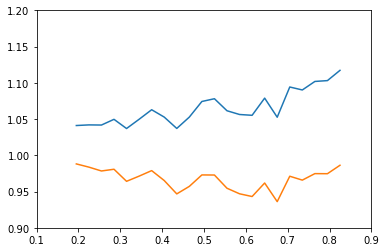

In [10]:
if do_isoapply:
    for ratio in ratios:
        if ratio[1]=='H2': #Only do isoscalar correction for EMC ratios
            df = pd.read_csv(outf + "dataframes/post_rc/" + ratio[0] + "_" + ratio[1] + ".csv", index_col=0)
            
            A = getattr(cor,ratio[0] + 'Nucleons')()
            Z = getattr(cor,ratio[0] + 'Z')()
            
            df['Isoscalar_Ratio'] = df.apply(lambda x: x.Ratio * iso.iso_cor(x.BinCenter,A,Z), axis=1)
            df['IsoCor'] = df.apply(lambda x: iso.iso_cor(x.BinCenter,A,Z), axis=1)
            df['IsoCorError'] = df.apply(lambda x: iso.iso_err(x.BinCenter,A,Z)/iso.iso_cor(x.BinCenter,A,Z), axis=1)
            #df.RelSyst = df.apply(lambda x: (x.RelSyst**2 + x.IsoCorError**2)**(1./2.) if x.Ratio!=0 else 0, axis=1)
            display(df)
            plt.plot(df.BinCenter,df.Ratio)
            plt.plot(df.BinCenter,df.Isoscalar_Ratio)
            plt.gca().set(ylim=(0.9,1.2), xlim=(0.1,0.9))
            
            df['RelRatioError'] = df.apply(lambda x: (x.RelSyst**2 + x.RelPre**2)**(1./2.), axis=1)
            df['RelIsoscalarRatioError'] = df.apply(lambda x: (x.RelSyst**2 + x.RelPre**2 + x.IsoCorError**2)**(1./2.), axis=1)
            
            df.to_csv(outf + "dataframes/final/" + ratio[0] + "_" + ratio[1] + ".csv")